In [ ]:
# Part of the code adapted from https://github.com/pyg-team/pytorch_geometric/tree/master/examples

In [ ]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 16.5 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=90addba8dfe8cd23f411f481d99562f5115a0a8040f5f6d010ef7da6e9584639
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
import torch
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [443]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import Embedding, Linear

import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import SAGEConv, GCNConv
from torch_geometric.nn import GATConv, HypergraphConv
from torch_geometric.nn.conv.gcn_conv import gcn_norm

dataset = MovieLens('./data', model_name='all-MiniLM-L6-v2')

In [444]:
tensor = torch.zeros(10352,610)
for i in range(610):
    tensor[i+9742][i] = 1

In [445]:
device = 'cuda'
data = dataset[0].to_homogeneous(dummy_values=False)

In [446]:
import numpy as np
data.x = tensor

In [447]:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0,
    key = 'edge_label'
)(data)

In [448]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(-1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.linear = Linear(hidden_channels, 1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index).relu()

    def decode(self, z, edge_label_index):
        return self.linear((z[edge_label_index[0]] * z[edge_label_index[1]])).reshape(-1)

In [449]:
model = GCNNet(dataset.num_features, 64, 64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [450]:
train_data.to(device)
val_data.to(device)
test_data.to(device)

Data(edge_index=[2, 90753], node_type=[10352], edge_type=[90753], x=[10352, 610], edge_label=[10083], edge_label_index=[2, 10083])

In [451]:
train_data

Data(edge_index=[2, 80670], node_type=[10352], edge_type=[80670], x=[10352, 610], edge_label=[80670], edge_label_index=[2, 80670])

In [452]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model.encode(
        train_data.x,
        train_data.edge_index
    )
    out = model.decode(out, train_data.edge_label_index)
    ground_truth = train_data.edge_label.float()
    ground_truth[ground_truth<4] = 0
    ground_truth[ground_truth>=4] = 1
    loss = F.binary_cross_entropy_with_logits(out.reshape(-1), ground_truth.reshape(-1))
    loss.backward()
    optimizer.step()
    return float(loss)

In [453]:
from sklearn.metrics import roc_auc_score

In [454]:
@torch.no_grad()
def test(data):
    model.eval()
    out = model.encode(
        data.x,
        data.edge_index
    )
    out = model.decode(out, data.edge_label_index)
    ground_truth = data.edge_label.float().cpu().numpy()
    ground_truth[ground_truth<4] = 0
    ground_truth[ground_truth>=4] = 1
    # print(ground_truth)
    # print(np.shape(ground_truth),np.shape(pred))
    # print(ground_truth.size(),out.size())
    auc = roc_auc_score(ground_truth.reshape(-1), out.reshape(-1).detach().cpu())
    return float(auc)

In [455]:
import time

In [456]:
start_time = time.time()
best_auc = 0
loss_gcn = []
for epoch in range(1, 1052):
    loss = train()
    train_auc = test(train_data)
    val_auc = test(val_data)
    test_auc = test(test_data)
    loss_gcn.append(test_auc)
    if test_auc >= best_auc:
      best_auc = test_auc
    if epoch % 150 == 1:
      print(f'Epoch: {epoch:04d}, Loss: {loss:.4f}, Train: {train_auc:.4f}, '
            f'Val: {val_auc:.4f}, Test: {test_auc:.4f}')
print("time elapsed:", time.time() - start_time)
print(f"Best test auc: {best_auc:.4f}")

Epoch: 0001, Loss: 0.6946, Train: 0.4386, Val: 0.4272, Test: 0.4242
Epoch: 0151, Loss: 0.6038, Train: 0.7409, Val: 0.7289, Test: 0.7290
Epoch: 0301, Loss: 0.5655, Train: 0.7775, Val: 0.7659, Test: 0.7633
Epoch: 0451, Loss: 0.5390, Train: 0.8019, Val: 0.7863, Test: 0.7799
Epoch: 0601, Loss: 0.5302, Train: 0.8094, Val: 0.7890, Test: 0.7813
Epoch: 0751, Loss: 0.5237, Train: 0.8149, Val: 0.7916, Test: 0.7824
Epoch: 0901, Loss: 0.5141, Train: 0.8225, Val: 0.7938, Test: 0.7838
Epoch: 1051, Loss: 0.5032, Train: 0.8313, Val: 0.7948, Test: 0.7838
time elapsed: 66.51217436790466
Best test auc: 0.7840


In [457]:
class GATNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(-1, hidden_channels)
        self.conv2 = GATConv(hidden_channels, out_channels)
        self.linear = Linear(hidden_channels, 1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index).relu()

    def decode(self, z, edge_label_index):
        return self.linear((z[edge_label_index[0]] * z[edge_label_index[1]])).reshape(-1)

In [458]:
model = GATNet(dataset.num_features, 64, 64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [459]:
start_time = time.time()
best_auc = 0
loss_gat = []
for epoch in range(1, 1052):
    loss = train()
    train_auc = test(train_data)
    val_auc = test(val_data)
    test_auc = test(test_data)
    loss_gat.append(test_auc)
    if test_auc >= best_auc:
      best_auc = test_auc
    if epoch % 150 == 1:
      print(f'Epoch: {epoch:04d}, Loss: {loss:.4f}, Train: {train_auc:.4f}, '
            f'Val: {val_auc:.4f}, Test: {test_auc:.4f}')
print("time elapsed:", time.time() - start_time)
print(f"Best test auc: {best_auc:.4f}")

Epoch: 0001, Loss: 0.6928, Train: 0.5411, Val: 0.5358, Test: 0.5256
Epoch: 0151, Loss: 0.6248, Train: 0.7348, Val: 0.7335, Test: 0.7363
Epoch: 0301, Loss: 0.5620, Train: 0.7813, Val: 0.7763, Test: 0.7750
Epoch: 0451, Loss: 0.5489, Train: 0.7927, Val: 0.7835, Test: 0.7789
Epoch: 0601, Loss: 0.5402, Train: 0.8003, Val: 0.7872, Test: 0.7812
Epoch: 0751, Loss: 0.5322, Train: 0.8073, Val: 0.7894, Test: 0.7832
Epoch: 0901, Loss: 0.5243, Train: 0.8139, Val: 0.7898, Test: 0.7842
Epoch: 1051, Loss: 0.5143, Train: 0.8224, Val: 0.7893, Test: 0.7846
time elapsed: 71.02622556686401
Best test auc: 0.7846


In [460]:
class SAGENet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(-1, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.linear = Linear(hidden_channels, 1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index).relu()

    def decode(self, z, edge_label_index):
        return self.linear((z[edge_label_index[0]] * z[edge_label_index[1]])).reshape(-1)

In [461]:
model = SAGENet(dataset.num_features, 64, 64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [462]:
start_time = time.time()
best_auc = 0
loss_sage = []
for epoch in range(1, 1052):
    loss = train()
    train_auc = test(train_data)
    val_auc = test(val_data)
    test_auc = test(test_data)
    loss_sage.append(test_auc)
    if test_auc >= best_auc:
      best_auc = test_auc
    if epoch % 150 == 1:
      print(f'Epoch: {epoch:04d}, Loss: {loss:.4f}, Train: {train_auc:.4f}, '
            f'Val: {val_auc:.4f}, Test: {test_auc:.4f}')
print("time elapsed:", time.time() - start_time)
print(f"Best test auc: {best_auc:.4f}")

Epoch: 0001, Loss: 0.6942, Train: 0.4960, Val: 0.4978, Test: 0.4868
Epoch: 0151, Loss: 0.6200, Train: 0.7502, Val: 0.7430, Test: 0.7402
Epoch: 0301, Loss: 0.5432, Train: 0.7983, Val: 0.7871, Test: 0.7815
Epoch: 0451, Loss: 0.5310, Train: 0.8082, Val: 0.7925, Test: 0.7871
Epoch: 0601, Loss: 0.5232, Train: 0.8141, Val: 0.7945, Test: 0.7891
Epoch: 0751, Loss: 0.5146, Train: 0.8211, Val: 0.7951, Test: 0.7896
Epoch: 0901, Loss: 0.5024, Train: 0.8308, Val: 0.7942, Test: 0.7883
Epoch: 1051, Loss: 0.4881, Train: 0.8419, Val: 0.7919, Test: 0.7848
time elapsed: 71.11251211166382
Best test auc: 0.7897


In [ ]:
'''
Now moving on to Heteorogenous graph

'''

In [492]:
# Add reverse relation for message passing
dataset = MovieLens('./data', model_name='all-MiniLM-L6-v2')
data = dataset[0]
data['user'].x = torch.arange(data['user'].num_nodes)
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

In [493]:
data['user', 'movie'].edge_label = data['user', 'movie'].edge_label.long()

In [494]:
# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly.
# We can leverage the `RandomLinkSplit()` transform for this from PyG:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0,
    edge_types=("user", "rates", "movie"),
    rev_edge_types=("movie", "rev_rates", "user"), 
)(data)

In [466]:
test_data

HeteroData(
  movie={ x=[9742, 404] },
  user={
    num_nodes=610,
    x=[610]
  },
  (user, rates, movie)={
    edge_index=[2, 90753],
    edge_label=[10083],
    edge_label_index=[2, 10083]
  },
  (movie, rev_rates, user)={ edge_index=[2, 90753] }
)

In [495]:
# Generate the co-occurence matrix of movies<>movies:
metapath = [('movie', 'rev_rates', 'user'), ('user', 'rates', 'movie')]
train_data = T.AddMetaPaths(metapaths=[metapath])(train_data)

# Apply normalization to filter the metapath:
_, edge_weight = gcn_norm(
    train_data['movie', 'movie'].edge_index,
    num_nodes=train_data['movie'].num_nodes,
    add_self_loops=False,
)
edge_index = train_data['movie', 'movie'].edge_index[:, edge_weight > 0.002]

train_data['movie', 'metapath_0', 'movie'].edge_index = edge_index
val_data['movie', 'metapath_0', 'movie'].edge_index = edge_index
test_data['movie', 'metapath_0', 'movie'].edge_index = edge_index

In [468]:
class MovieGNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()

        self.conv1 = GCNConv(-1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.lin(x)

In [469]:
class UserGNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(-1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        movie_x = self.conv1(x_dict, edge_index_dict).relu()

        movie_x = self.conv2(movie_x, edge_index_dict).relu()

        movie_x = self.conv3(movie_x, edge_index_dict).relu()

        return self.lin(movie_x)

In [470]:
class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_src, z_dst, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_src[row], z_dst[col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)

In [471]:
class Model(torch.nn.Module):
    def __init__(self, num_users, hidden_channels, out_channels):
        super().__init__()
        self.user_emb = Embedding(num_users, hidden_channels)
        self.user_encoder = UserGNNEncoder(hidden_channels, out_channels)
        self.movie_encoder = MovieGNNEncoder(hidden_channels, out_channels)
        self.decoder = EdgeDecoder(out_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = {}
        x_dict['user'] = self.user_emb(x_dict['user'])
        z_dict['user'] = self.user_encoder(x_dict['movie'],
            edge_index_dict[('movie', 'rev_rates', 'user')])
        z_dict['movie'] = self.movie_encoder(
            x_dict['movie'],
            edge_index_dict[('movie', 'metapath_0', 'movie')],
        )
        return self.decoder(z_dict['user'], z_dict['movie'], edge_label_index)

In [472]:
device = 'cuda'

In [473]:
model = Model(data['user'].num_nodes, hidden_channels=64, out_channels=64)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [474]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(
        train_data.x_dict,
        train_data.edge_index_dict,
        train_data['user', 'movie'].edge_label_index,
    )
    ground_truth = train_data["user", "rates", "movie"].edge_label.float()
    ground_truth[ground_truth<4] = 0
    ground_truth[ground_truth>=4] = 1
    loss = F.binary_cross_entropy_with_logits(out.reshape(-1), ground_truth.reshape(-1))
    loss.backward()
    optimizer.step()
    return float(loss)

In [409]:
from sklearn.metrics import roc_auc_score

In [475]:
@torch.no_grad()
def test(data):
    model.eval()
    out = model(
        data.x_dict,
        data.edge_index_dict,
        data['user', 'movie'].edge_label_index,
    )
    ground_truth = data["user", "rates", "movie"].edge_label.float().cpu().numpy()
    ground_truth[ground_truth<4] = 0
    ground_truth[ground_truth>=4] = 1
    # print(ground_truth)
    # print(np.shape(ground_truth),np.shape(pred))
    auc = roc_auc_score(ground_truth.reshape(-1), out.reshape(-1).detach().cpu())
    return float(auc)

In [498]:
train_data.to(device)
val_data.to(device)
test_data.to(device)

HeteroData(
  movie={ x=[9742, 404] },
  user={
    num_nodes=610,
    x=[610]
  },
  (user, rates, movie)={
    edge_index=[2, 90753],
    edge_label=[10083],
    edge_label_index=[2, 10083]
  },
  (movie, rev_rates, user)={ edge_index=[2, 90753] },
  (movie, metapath_0, movie)={ edge_index=[2, 76616] }
)

In [477]:
start_time = time.time()
best_auc = 0
loss_gcn_2 = []
for epoch in range(1, 1052):
    loss = train()
    train_auc = test(train_data)
    val_auc = test(val_data)
    test_auc = test(test_data)
    loss_gcn_2.append(test_auc)
    if test_auc >= best_auc:
      best_auc = test_auc
    if epoch % 150 == 1:
      print(f'Epoch: {epoch:04d}, Loss: {loss:.4f}, Train: {train_auc:.4f}, '
            f'Val: {val_auc:.4f}, Test: {test_auc:.4f}')
print("time elapsed:", time.time() - start_time)
print(f"Best test auc: {best_auc:.4f}")

Epoch: 0001, Loss: 0.6955, Train: 0.6140, Val: 0.6155, Test: 0.6080
Epoch: 0151, Loss: 0.5699, Train: 0.7694, Val: 0.7430, Test: 0.7347
Epoch: 0301, Loss: 0.5231, Train: 0.8136, Val: 0.7698, Test: 0.7588
Epoch: 0451, Loss: 0.5026, Train: 0.8332, Val: 0.7771, Test: 0.7672
Epoch: 0601, Loss: 0.4880, Train: 0.8415, Val: 0.7776, Test: 0.7678
Epoch: 0751, Loss: 0.4853, Train: 0.8469, Val: 0.7776, Test: 0.7655
Epoch: 0901, Loss: 0.4893, Train: 0.8400, Val: 0.7640, Test: 0.7591
Epoch: 1051, Loss: 0.4673, Train: 0.8562, Val: 0.7747, Test: 0.7645
time elapsed: 80.73138213157654
Best test auc: 0.7703


In [ ]:
# Now we use graphSage

In [478]:
class SageMovieGNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()

        self.conv1 = SAGEConv(-1, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.lin(x)

In [479]:
class SageUserGNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), hidden_channels)
        self.conv3 = SAGEConv((-1, -1), hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        movie_x = self.conv1(
            x_dict['movie'],
            edge_index_dict[('movie', 'metapath_0', 'movie')],
        ).relu()

        user_x = self.conv2(
            (x_dict['movie'], x_dict['user']),
            edge_index_dict[('movie', 'rev_rates', 'user')],
        ).relu()

        user_x = self.conv3(
            (movie_x, user_x),
            edge_index_dict[('movie', 'rev_rates', 'user')],
        ).relu()

        return self.lin(user_x)

In [480]:
class SageEdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_src, z_dst, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_src[row], z_dst[col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)

In [481]:
class SageModel(torch.nn.Module):
    def __init__(self, num_users, hidden_channels, out_channels):
        super().__init__()
        self.user_emb = Embedding(num_users, hidden_channels)
        self.user_encoder = SageUserGNNEncoder(hidden_channels, out_channels)
        self.movie_encoder = SageMovieGNNEncoder(hidden_channels, out_channels)
        self.decoder = SageEdgeDecoder(out_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = {}
        x_dict['user'] = self.user_emb(x_dict['user'])
        z_dict['user'] = self.user_encoder(x_dict, edge_index_dict)
        z_dict['movie'] = self.movie_encoder(
            x_dict['movie'],
            edge_index_dict[('movie', 'metapath_0', 'movie')],
        )
        return self.decoder(z_dict['user'], z_dict['movie'], edge_label_index)

In [482]:
model = SageModel(data['user'].num_nodes, hidden_channels=64, out_channels=64)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [483]:
start_time = time.time()
best_auc = 0
loss_sage_2 = []
for epoch in range(1, 1052):
    loss = train()
    train_auc = test(train_data)
    val_auc = test(val_data)
    test_auc = test(test_data)
    loss_sage_2.append(test_auc)
    if test_auc >= best_auc:
      best_auc = test_auc
    if epoch % 150 == 1:
      print(f'Epoch: {epoch:04d}, Loss: {loss:.4f}, Train: {train_auc:.4f}, '
            f'Val: {val_auc:.4f}, Test: {test_auc:.4f}')
print("time elapsed:", time.time() - start_time)
print(f"Best test auc: {best_auc:.4f}")

Epoch: 0001, Loss: 0.6934, Train: 0.5910, Val: 0.5991, Test: 0.5915
Epoch: 0151, Loss: 0.4988, Train: 0.8360, Val: 0.7954, Test: 0.7906
Epoch: 0301, Loss: 0.4750, Train: 0.8597, Val: 0.7925, Test: 0.7903
Epoch: 0451, Loss: 0.4445, Train: 0.8706, Val: 0.7885, Test: 0.7836
Epoch: 0601, Loss: 0.4265, Train: 0.8824, Val: 0.7860, Test: 0.7815
Epoch: 0751, Loss: 0.4061, Train: 0.8933, Val: 0.7821, Test: 0.7743
Epoch: 0901, Loss: 0.3968, Train: 0.8995, Val: 0.7788, Test: 0.7700
Epoch: 1051, Loss: 0.3751, Train: 0.9105, Val: 0.7738, Test: 0.7657
time elapsed: 86.35380482673645
Best test auc: 0.7934


In [ ]:
# Graph Attention Networks

In [484]:
class AttentionMovieGNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()

        self.conv1 = GATConv(-1, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.lin(x)

In [485]:
class AttentionUserGNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels)
        self.conv2 = GATConv((-1, -1), hidden_channels)
        self.conv3 = GATConv((-1, -1), hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        movie_x = self.conv1(
            x_dict['movie'],
            edge_index_dict[('movie', 'metapath_0', 'movie')],
        ).relu()

        user_x = self.conv2(
            (x_dict['movie'], x_dict['user']),
            edge_index_dict[('movie', 'rev_rates', 'user')],
        ).relu()

        user_x = self.conv3(
            (movie_x, user_x),
            edge_index_dict[('movie', 'rev_rates', 'user')],
        ).relu()

        return self.lin(user_x)

In [486]:
class AttentionEdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_src, z_dst, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_src[row], z_dst[col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)

In [487]:
class AttentionModel(torch.nn.Module):
    def __init__(self, num_users, hidden_channels, out_channels):
        super().__init__()
        self.user_emb = Embedding(num_users, hidden_channels)
        self.user_encoder = AttentionUserGNNEncoder(hidden_channels, out_channels)
        self.movie_encoder = AttentionMovieGNNEncoder(hidden_channels, out_channels)
        self.decoder = SageEdgeDecoder(out_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = {}
        x_dict['user'] = self.user_emb(x_dict['user'])
        z_dict['user'] = self.user_encoder(x_dict, edge_index_dict)
        z_dict['movie'] = self.movie_encoder(
            x_dict['movie'],
            edge_index_dict[('movie', 'metapath_0', 'movie')],
        )
        return self.decoder(z_dict['user'], z_dict['movie'], edge_label_index)

In [496]:
model = AttentionModel(data['user'].num_nodes, hidden_channels=64, out_channels=64)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [499]:
start_time = time.time()
best_auc = 0
loss_gat_2 = []
for epoch in range(1, 1052):
    loss = train()
    train_auc = test(train_data)
    val_auc = test(val_data)
    test_auc = test(test_data)
    loss_gat_2.append(test_auc)
    if test_auc >= best_auc:
      best_auc = test_auc
    if epoch % 150 == 1:
      print(f'Epoch: {epoch:04d}, Loss: {loss:.4f}, Train: {train_auc:.4f}, '
            f'Val: {val_auc:.4f}, Test: {test_auc:.4f}')
print("time elapsed:", time.time() - start_time)
print(f"Best test auc: {best_auc:.4f}")

Epoch: 0001, Loss: 0.6925, Train: 0.6043, Val: 0.6060, Test: 0.6037
Epoch: 0151, Loss: 0.5380, Train: 0.8045, Val: 0.7657, Test: 0.7600
Epoch: 0301, Loss: 0.5013, Train: 0.8314, Val: 0.7770, Test: 0.7662
Epoch: 0451, Loss: 0.4872, Train: 0.8405, Val: 0.7777, Test: 0.7646
Epoch: 0601, Loss: 0.4720, Train: 0.8494, Val: 0.7800, Test: 0.7654
Epoch: 0751, Loss: 0.4639, Train: 0.8545, Val: 0.7798, Test: 0.7651
Epoch: 0901, Loss: 0.4516, Train: 0.8624, Val: 0.7783, Test: 0.7631
Epoch: 1051, Loss: 0.4435, Train: 0.8684, Val: 0.7774, Test: 0.7642
time elapsed: 85.92288851737976
Best test auc: 0.7690


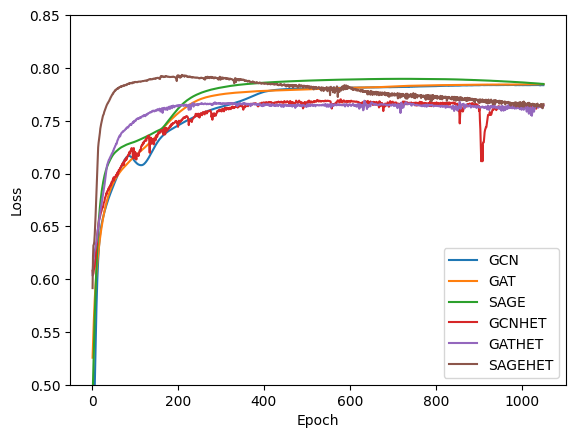

In [500]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

fig, ax = plt.subplots()
data = {
    "loss_gcn": loss_gcn,
    "loss_gat": loss_gat,
    "loss_sage": loss_sage,
    "loss_gcn_2": loss_gcn_2,
    "loss_gat_2": loss_gat_2,
    "loss_sage_2": loss_sage_2,
}
!touch data.pkl
with open("data.pkl", "wb") as f:
    pickle.dump(data, f)

x = np.arange(1, len(data['loss_gcn']) + 1)
y_gcn = np.array(data['loss_gcn'])
y_gat = np.array(data['loss_gat'])
y_sage = np.array(data['loss_sage'])
y_gcn_2 = np.array(data['loss_gcn_2'])
y_gat_2 = np.array(data['loss_gat_2'])
y_sage_2 = np.array(data['loss_sage_2'])
# y_het_2 = np.array(data['loss_het'])

ax.plot(x, y_gcn, label="GCN")
ax.plot(x, y_gat, label="GAT")
ax.plot(x, y_sage, label="SAGE")
ax.plot(x, y_gcn_2, label="GCNHET")
ax.plot(x, y_gat_2, label="GATHET")
ax.plot(x, y_sage_2, label="SAGEHET")
# ax.plot(x, y_het_2, label="HETGNN")
ax.set_ylim(0.5, 0.85)

ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

plt.savefig("loss_curve.pdf")